# Archivos .nc

En esta notebook se muestra un ejemplo de como guardar/leer la información en archivos .nc. NC es un formato binario abierto e independiente de la plataforma utilizado por las herramientas de NetCDF administradas por Unidata. El formato NC, a través de API y bibliotecas, es compatible con muchos lenguajes de programación populares y facilita la creación y el intercambio de datos científicos. Al final de la notebook se muestra una forma de guardar los datos en archivos de formato .csv.

En nuestro caso utilizamos la librería [netCDF4](https://unidata.github.io/netcdf4-python/#version-157) para python. También se utiliza otras librerías para hacer algunas operaciones sobre los datos. 

In [3]:
from netCDF4 import Dataset
import numpy as np
import matplotlib.pyplot as plt
import utils as ut # para graficos y demas...
import utilsDatos as utd
from scipy.interpolate import griddata
from scipy.optimize import curve_fit
import scipy as sp
from pylab import imread, imshow, gray, mean
from skimage import filters
import analisis_anom as tr # tiene algunas funciones de fatiando a terra

%matplotlib inline

Primero cargamos el archivo con los datos y vemos que información contiene. No olvidar el modo de lectura (*mode*='r')

In [4]:
nombre = 'datienzo.nc'
data = Dataset(nombre, mode='r')
data

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4 data model, file format HDF5):
    Conventions: CF-1.7
    title: Produced by grdmath
    history: grdmath temp_3_Mapa_Sloggett_Bouguer_1665_FAA.nc temp_3_Mapa_Sloggett_Bouguer_1665_water.nc SUB = temp_3_Mapa_Sloggett_Bouguer_1665_Bouguer.nc -fg
    GMT_version: 6.1.1 [64-bit] [MP]
    dimensions(sizes): lon(3642), lat(3179)
    variables(dimensions): float64 lon(lon), float64 lat(lat), float32 z(lat, lon)
    groups: 

In [5]:
lons = data.variables['lon'][:] # se cargan los datos de la longitud
lats = data.variables['lat'][:] #se cargan los datos  de la latitud
dato = data.variables['z'][:]   # se carga el dato de interés
print('dato:',np.shape(dato))
nt,nm = dato.shape

dato: (3179, 3642)


Para las operaciones que se quieren realizar se pasa las unidades de miligales a las del SI. 

In [6]:
dato = ut.mgal2si(dato)

Se tienen las corrdenadas, pero vamos a necesitar también las grillas de coordenadas.

In [7]:
xc, yc = utd.obt_coord(lons,lats,dato)

Se acondicionan los datos para poder utilizar algunas de las funciones de librerías de [Fatiando a terra](https://www.fatiando.org/)

In [8]:
gauss = sp.ndimage.filters.gaussian_filter(dato,1.) # optativo: aplica un filtro de suavizado al dato

d = gauss.ravel() # arregla el dato, X e Y pasando de algo 2D a 1D.

y = xc.ravel() # x, y se cambian porque X en la librería esta en dirección North-South. 
x = yc.ravel() # 

## Algunas operaciones...

Para obtener la primer derivada en Z sencillamente se llama a la función derivz(). Observar que se puede cambiar el orden del operador derivada. De esta forma:

* order=1: primer derivada
* order=2: segunda derivada

In [9]:
zd = tr.derivz(x, y, d, dato.shape,order=1)# primer derivada de la vertical (o Z)

zd2D = np.reshape(zd, (nt, nm)) # arreglamos el dato obtenido llevandolo a algo 2D 

dz = zd2D # por conveniencia... :p

nice plot!


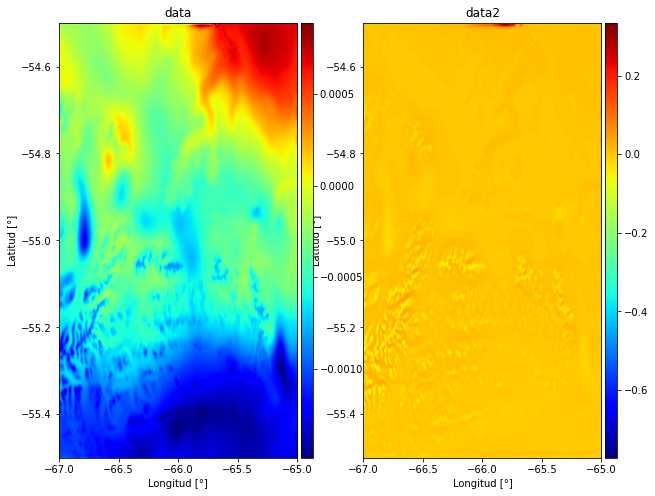

In [10]:
ut.plot_1x2(dato,dz,lons,lats)

Otra operación que se puede realizar es calcular el gradiente horizontal de gravedad:

nice plot!


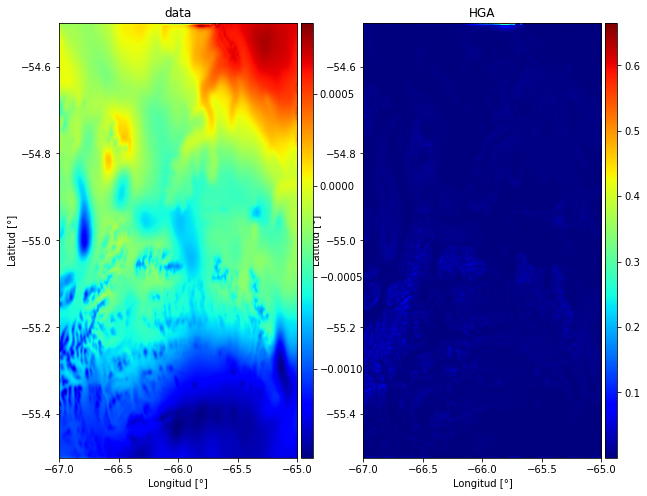

In [11]:
hh = tr.hga(x, y, d, dato.shape)
hh = np.reshape(hh, (nt, nm))
ut.plot_1x2(dato,hh,lons,lats,name2='HGA')

Finalmente, una vez que tenemos datos nuevos podemos guardarlos como archivo .nc. Para esto, usamos la función f_txt2nc donde solo le pasamos como argumentos la longitud, latitud y el dato que queremos gaurdar. 

In [12]:
utd.f_txt2nc(lons,lats,dz,name_f='slo_1der')

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4_CLASSIC data model, file format HDF5):
    title: Mis datos
    description: se guardan las coordenadas y algun otro dato de interes
    history: Fecha de cracion hoy
    source: Tutorial: https://github.com/Unidata/netcdf4-python/blob/master/examples/writing_netCDF.ipynb
    dimensions(sizes): lat(3179), lon(3642), dato(0)
    variables(dimensions): float32 lat(lat), float32 lon(lon), float64 dato(lat, lon)
    groups: 
Dataset is closed!


Obviamente se puede guardar otro tipo de información en este tipo de archivos como se muestra a continuación.

In [13]:
titulo = "GH dato Slo"
descr = "se guardan las coordenadas y el gradiente horizonal de gravedad (mgal)"
historia = "Fecha de cracion hoy"
sourc = "Github gabriel"
name_f = 'slo_HG'


utd.f_txt2nc(lons,lats,hh,name_f,titulo,descr,historia,sourc)

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4_CLASSIC data model, file format HDF5):
    title: GH dato Slo
    description: se guardan las coordenadas y el gradiente horizonal de gravedad (mgal)
    history: Fecha de cracion hoy
    source: Github gabriel
    dimensions(sizes): lat(3179), lon(3642), dato(0)
    variables(dimensions): float32 lat(lat), float32 lon(lon), float64 dato(lat, lon)
    groups: 
Dataset is closed!


También es posible guardar toda esta info en un archivo .csv. Para esto utilizamos la librería pandas.

In [14]:
import pandas as pd
import csv

En la variable dc almacenamos el dato que se quiere guardar en el archivo csv. Con esto se arma un diccionario donde se guarda la longitud, latitud y dato. Observar que se llevan los datos a arreglos de 1D. 

In [43]:
dc = hh
all = {'long':xc.ravel(),'lat':yc.ravel(),'data':dc.ravel()}

Se guarda el diccionario en dataframe de pandas

In [44]:
all_df = pd.DataFrame(data=all) # Se convierte la info capturada a un dataframe
all_df.head() # vemos com ose guardaron las cosas...

,long,lat,data
0,-67.000663,-55.500457,0.004203
1,-67.000113,-55.500457,0.004362
2,-66.999564,-55.500457,0.004628
3,-66.999014,-55.500457,0.004866
4,-66.998464,-55.500457,0.005093


Y ahora sí se lleva esta info al archivo csv:

In [45]:
name = 'nombre_del_archivo'
outfile = name+'.csv'

all_df.to_csv(outfile,index=False,sep=',')


se debe de tener en cuenta que ahora los datos estan en un arreglo unidemnsional por lo que será necesario realizar 
un reshape según con la herramienta que se la quiera trabajar después. 